In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

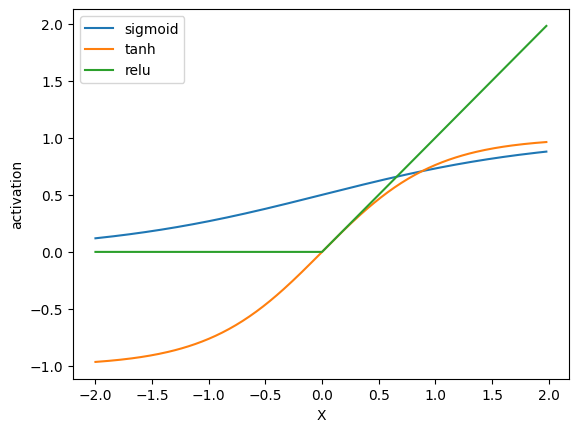

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(-2, 2, 0.02)

sigmoid = 1./(1+np.exp(-X))
tanh = (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
relu = np.max([np.zeros(len(X)), X], axis=0)

plt.plot(X, sigmoid)
plt.plot(X, tanh)
plt.plot(X, relu)

plt.xlabel('X')
plt.ylabel('activation')
plt.legend(['sigmoid', 'tanh', 'relu'])

plt.show()

In [2]:
import pandas as pd
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)
print(X_train[0].shape)
print(type(X_train))

(60000, 28, 28)
(10000, 28, 28)
uint8
(28, 28)
<class 'numpy.ndarray'>


Smoothing

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

Visualize image data

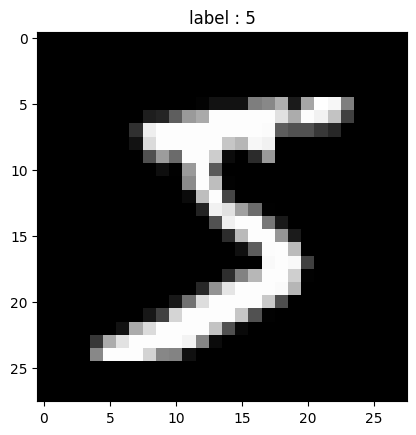

In [5]:
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

Preprocessing

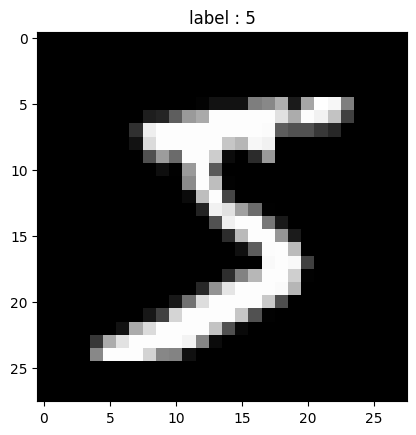

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float64) # Convert to float type
image -= 105.35 # Intentionally try to create a negative decimal value
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # Check the value

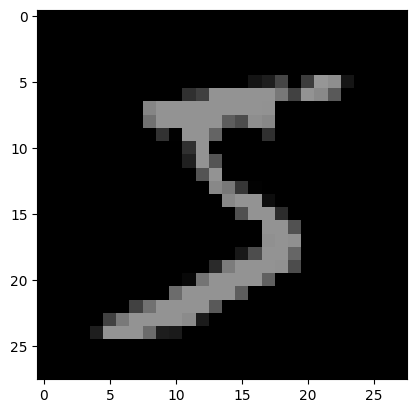

In [7]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

Pretreatment

In [8]:
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255
print(X_train.max())
print(X_train.min())

1.0
0.0


In [29]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


Mini-batch Processing

In [11]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int64)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [12]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch))
print(get_mini_batch[5])

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([9, 2, 7, 9, 0, 7, 3, 0, 2, 1, 7, 4, 3, 3, 0, 9, 8, 2, 0, 6],
      dtype=uint8))


[Problem 1] Creating a code to determine the initial weight value

In [13]:
n_features = 784
n_nodes1 = 400
sigma = 0.01
n_output = 10
W1 = sigma * np.random.randn(n_features, n_nodes1)
n_nodes2 = 200
n_nodes3 = 10
W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
B1 = sigma * np.random.randn(n_nodes1)
B2 = sigma * np.random.randn(n_nodes2)
W3 = sigma * np.random.randn(n_nodes2, n_output)
B3 = sigma * np.random.randn(n_nodes3)
print("W1-->",W1.shape)
print("W2-->",W2.shape)
print("b1-->",B1.shape)
print("b2-->",B2.shape)
print("W3-->",W3.shape)
print("b3-->",B3.shape)

W1--> (784, 400)
W2--> (400, 200)
b1--> (400,)
b2--> (200,)
W3--> (200, 10)
b3--> (10,)


Problem 2

In [15]:
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, n_epoch=50,n_features=784,n_nodes1=400,n_nodes2=200,
                 n_output=10, sigma=0.01, n_batch=20, activate_function_key='tanh',
                 lr=0.01, verbose=False):
        self.n_epoch = n_epoch
        self.verbose = verbose
        self.n_batch = n_batch
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_batch = n_batch
        self.activate_function_key = activate_function_key
        self.lr = lr
        #self.epoch = 10

    def initial_weight(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = np.zeros(self.n_nodes1)
        self.B2 = np.zeros(self.n_nodes2)
        self.B3 = np.zeros(self.n_output)

    def activation_function(self,X):
        if self.activate_function_key == 'sigmoid':
          return 1/(1+np.exp(-X))

        elif self.activate_function_key == 'tanh':
          return np.tanh(X)

    def softmax(self, X):
        return np.exp(X-np.max(X)) / np.sum(np.exp(X-np.max(X)), axis=1,keepdims=True)

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))

    def gradient_descent(self,X,y,yt):

            #3rd layer
            delta_A3 = (y-yt)/self.n_batch
            delta_B3 = np.sum(delta_A3,axis=0)
            delta_W3 = np.dot(self.Z2.T,delta_A3)
            delta_Z2 = np.dot(delta_A3,self.W3.T)

            self.W3 -= self.lr*delta_W3
            self.B3 -= self.lr*delta_B3

            #2nd layer
            if self.activate_function_key == 'sigmoid':
                delta_A2 = delta_Z2*(1-self.activation_function(self.Z2))*self.activation_function(self.Z2)

            elif self.activate_function_key == 'tanh':
                delta_A2 = delta_Z2*(1-np.tanh(self.Z2)**2)

            delta_B2 = np.sum(delta_A2,axis=0)
            delta_W2 = np.dot(self.Z1.T,delta_A2)
            delta_Z1 = np.dot(delta_A2,self.W2.T)

            self.W2 -= self.lr*delta_W2
            self.B2 -= self.lr*delta_B2

            #1st layer
            if self.activate_function_key == 'sigmoid':
                delta_A1 = delta_Z1*(1-self.activation_function(self.Z1))*self.activation_function(self.Z1)

            elif self.activate_function_key == 'tanh':
                delta_A1 = delta_Z1*(1-np.tanh(self.Z1)**2)

            delta_B1 = np.sum(delta_A1,axis=0)
            delta_W1 = np.dot(X.T,delta_A1)

            self.W1 -= self.lr*delta_W1
            self.B1 -= self.lr*delta_B1

    def fit(self, X, y, X_val=False, y_val=False):
        # Initialize weights
        self.initial_weight()

        # List to record the loss_function for epoch
        self.log_loss = []
        self.log_loss_val = []

        # Evaluate the estimation of Train data per epoch: Accuracy
        self.log_acc = []
        self.log_acc_val = []

        # Number of batches
        # self.n_batch = len(X) // self.batch_size

        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])

            for mini_X_train, mini_y_train in get_mini_batch:

                # 1st layer
                self.Z1 = self.activation_function(np.dot(mini_X_train,self.W1) + self.B1)

                # 2nd layer
                self.Z2 = self.activation_function(np.dot(self.Z1,self.W2) + self.B2)

                # 3rd layer
                yhat = self.softmax(np.dot(self.Z2,self.W3) + self.B3)

                # Backpropagation (stochastic gradient descent method)
                self.gradient_descent(mini_X_train,yhat,mini_y_train)

                # Record correct and estimated values for mini-batch data
                self.true_y = np.concatenate([self.true_y,np.argmax(mini_y_train,axis=1)])
                self.pred_y = np.concatenate([self.pred_y,np.argmax(yhat,axis=1)])

                # Loss function
                self.loss += self.loss_function(yhat,mini_y_train)

            # Record the loss function for each epoch
            self.log_loss.append(self.loss/len(get_mini_batch))

            # Accuracy
            acc = accuracy_score(self.true_y,self.pred_y)
            self.log_acc.append(acc)

            # Calculate once Val data has been entered
            if (type(X_val) != bool):
                # 1st layer
                self.Z1_val = self.activation_function(np.dot(X_val,self.W1) + self.B1)

                # 2nd layer
                self.Z2_val = self.activation_function(np.dot(self.Z1_val,self.W2) + self.B2)

                # 3rd layer (SoftMax function)
                yhat_val = self.softmax(np.dot(self.Z2_val,self.W3) + self.B3)

                # Loss Function
                self.loss_val = self.loss_function(yhat_val,y_val)
                self.log_loss_val.append(self.loss_val)

                # Accuracy

                acc_val = accuracy_score(np.argmax(y_val,axis=1), np.argmax(yhat_val,axis=1))
                self.log_acc_val.append(acc_val)

            # When verbose is set to true, output the learning process and other information
            if self.verbose:
                 print('epoch:{:>3} loss:{:>8,.3f} acc:{:>5,.3f}'.format(epoch,self.loss/self.n_batch,acc))

    def predict(self, X):
        # 1st layer
        self.pred_Z1 = self.activation_function(np.dot(X,self.W1) + self.B1)

        # 2nd layer
        self.pred_Z2 = self.activation_function(np.dot(self.pred_Z1,self.W2) + self.B2)

        return np.argmax(np.dot(self.pred_Z2,self.W3) + self.B3, axis=1)

In [16]:
X = X_train[0:20]

In [17]:
# Linear combination of the first layer
Z1 = np.dot(X,W1) + B1
print('Z1.shape:', Z1.shape)
print(Z1)

Z1.shape: (20, 400)
[[ 0.15673894 -0.03855511  0.01916788 ... -0.04599062 -0.03223885
   0.06408622]
 [ 0.03814278 -0.03714616  0.04955472 ... -0.02136113 -0.11044476
  -0.0839028 ]
 [ 0.05406947  0.11589425 -0.04944721 ... -0.02955708 -0.22307394
  -0.1740683 ]
 ...
 [ 0.14929133  0.04601857  0.11867453 ... -0.08095563 -0.0591222
  -0.24749081]
 [ 0.09354291 -0.03352293  0.08947592 ...  0.058164    0.02490591
  -0.01687406]
 [-0.15549985  0.11247632 -0.0914343  ...  0.07327414 -0.10787911
  -0.01877726]]


In [18]:
# Activation function for the first layer
sig1 = 1/(1+np.exp(-Z1))
print('sig1.shape:', sig1.shape)
print(sig1)

sig1.shape: (20, 400)
[[0.53910471 0.49036242 0.50479182 ... 0.48850437 0.49194099 0.51601607]
 [0.50953454 0.49071453 0.51238614 ... 0.49465992 0.47241684 0.4790366 ]
 [0.51351408 0.52894118 0.48764071 ... 0.49261127 0.44446163 0.45659247]
 ...
 [0.53725367 0.51150261 0.52963386 ... 0.47977214 0.48522375 0.43844119]
 [0.52336869 0.49162005 0.52235407 ... 0.5145369  0.50622616 0.49578159]
 [0.46120318 0.52808947 0.47715734 ... 0.51831034 0.47305635 0.49530582]]


In [19]:
# Linear combination of the second layer
Z2 = np.dot(sig1,W2) + B2
print('Z2.shape:', Z2.shape)
print(Z2)

Z2.shape: (20, 200)
[[-0.14429705 -0.05839795 -0.14504887 ...  0.1214958   0.03330527
  -0.22588014]
 [-0.14124131 -0.05643968 -0.14371274 ...  0.11631989  0.04391639
  -0.22543613]
 [-0.13917552 -0.05907416 -0.1430227  ...  0.11276645  0.04754388
  -0.22625177]
 ...
 [-0.14035381 -0.05926132 -0.13263106 ...  0.11375952  0.04872515
  -0.22803221]
 [-0.13548295 -0.06710359 -0.13653872 ...  0.11446716  0.04460062
  -0.22015643]
 [-0.13578368 -0.06247057 -0.1380095  ...  0.11475526  0.04356965
  -0.21788338]]


In [20]:
# Activation function for the second layer
sig2 = 1/(1+np.exp(-Z2))
print('sig2.shape:', sig2.shape)
print(sig2)

sig2.shape: (20, 200)
[[0.4639882  0.48540466 0.46380123 ... 0.53033664 0.50832555 0.44376885]
 [0.46474826 0.48589382 0.46413352 ... 0.52904723 0.51097733 0.44387845]
 [0.46526217 0.48523575 0.46430515 ... 0.52816178 0.51188373 0.44367712]
 ...
 [0.46496904 0.485189   0.46689076 ... 0.52840925 0.51217888 0.4432377 ]
 [0.46618098 0.48323039 0.46591825 ... 0.52858559 0.51114831 0.44518213]
 [0.46610614 0.48438743 0.46555228 ... 0.52865737 0.51089069 0.44574363]]


In [21]:
# Linear combination of the third layer
Z3 = np.dot(sig2,W3) + B3
print('Z3.shape:', Z3.shape)
print(Z3)

Z3.shape: (20, 10)
[[-0.06610846 -0.17020596 -0.0275882   0.05976596 -0.04838897  0.08130733
   0.02948833 -0.01611571  0.06466698 -0.08481708]
 [-0.06595709 -0.17021773 -0.02767828  0.05994895 -0.04847561  0.08141867
   0.02937895 -0.01619145  0.06499565 -0.08476481]
 [-0.06572264 -0.17010373 -0.02790686  0.05979322 -0.04823804  0.08112151
   0.02946198 -0.01608945  0.06521616 -0.08472239]
 [-0.06592168 -0.17011549 -0.02773213  0.05996559 -0.04831545  0.08136504
   0.02935349 -0.01612036  0.06497937 -0.08476716]
 [-0.06632558 -0.17009304 -0.02765123  0.05975591 -0.04812122  0.0812406
   0.02916695 -0.01613158  0.06518566 -0.0846169 ]
 [-0.06621836 -0.17018021 -0.0275601   0.05981999 -0.04819194  0.08114047
   0.02952496 -0.01602676  0.06511631 -0.08485574]
 [-0.06605495 -0.1702305  -0.02794933  0.05982792 -0.04858055  0.08142338
   0.0291854  -0.01605214  0.06472359 -0.08458678]
 [-0.06619371 -0.17025067 -0.02765333  0.05995898 -0.04808955  0.08120738
   0.02910856 -0.01613251  0.0648

In [22]:
# Activation function for third layer
sfmax = np.zeros([len(X),10])
for i in range(len(X)):
    sfmax[i] = np.exp(Z3[i]) / np.sum(np.exp(Z3[i]), axis=0)
print('sfmax.shape:', sfmax.shape)
print(sfmax)
print(np.sum(sfmax))

sfmax.shape: (20, 10)
[[0.09502074 0.08562675 0.09875238 0.1077668  0.09671947 0.11011343
  0.10455278 0.09989184 0.10829626 0.09325956]
 [0.09503042 0.0856215  0.09873859 0.10778118 0.0967063  0.11012023
  0.10453616 0.09987932 0.10832649 0.09325981]
 [0.09504988 0.08562872 0.09871309 0.1077612  0.0967264  0.11008425
  0.10454174 0.09988655 0.10834717 0.093261  ]
 [0.09503182 0.08562848 0.09873123 0.10778075 0.09671979 0.11011205
  0.10453134 0.09988436 0.1083225  0.09325767]
 [0.09499632 0.085633   0.09874221 0.10776141 0.0967415  0.11010168
  0.10451501 0.09988626 0.10834812 0.0932745 ]
 [0.09500471 0.08562392 0.09874934 0.10776628 0.09673284 0.11008858
  0.10455046 0.09989484 0.10833856 0.09325047]
 [0.09502863 0.08562717 0.09871963 0.10777665 0.09670379 0.11012945
  0.10452419 0.09990113 0.10830558 0.09328379]
 [0.09501107 0.0856215  0.09874431 0.10778582 0.09674683 0.1101006
  0.10451135 0.0998885  0.10831172 0.09327829]
 [0.09500542 0.08562193 0.09873964 0.10775208 0.09674204 0.

In [23]:
# without a for statement part 2
softmax = np.exp(Z3) / np.sum(np.exp(Z3), axis=1, keepdims=True)
print('softmax.shape:', softmax.shape)
print(softmax)
print(np.sum(softmax))

softmax.shape: (20, 10)
[[0.09502074 0.08562675 0.09875238 0.1077668  0.09671947 0.11011343
  0.10455278 0.09989184 0.10829626 0.09325956]
 [0.09503042 0.0856215  0.09873859 0.10778118 0.0967063  0.11012023
  0.10453616 0.09987932 0.10832649 0.09325981]
 [0.09504988 0.08562872 0.09871309 0.1077612  0.0967264  0.11008425
  0.10454174 0.09988655 0.10834717 0.093261  ]
 [0.09503182 0.08562848 0.09873123 0.10778075 0.09671979 0.11011205
  0.10453134 0.09988436 0.1083225  0.09325767]
 [0.09499632 0.085633   0.09874221 0.10776141 0.0967415  0.11010168
  0.10451501 0.09988626 0.10834812 0.0932745 ]
 [0.09500471 0.08562392 0.09874934 0.10776628 0.09673284 0.11008858
  0.10455046 0.09989484 0.10833856 0.09325047]
 [0.09502863 0.08562717 0.09871963 0.10777665 0.09670379 0.11012945
  0.10452419 0.09990113 0.10830558 0.09328379]
 [0.09501107 0.0856215  0.09874431 0.10778582 0.09674683 0.1101006
  0.10451135 0.0998885  0.10831172 0.09327829]
 [0.09500542 0.08562193 0.09873964 0.10775208 0.09674204 

In [24]:
# High parabolic tangent (verification)
(np.exp(Z1)-np.exp(-Z1))/(np.exp(Z1)+np.exp(-Z1))

array([[ 0.15546789, -0.03853602,  0.01916553, ..., -0.04595822,
        -0.03222769,  0.06399863],
       [ 0.0381243 , -0.03712908,  0.04951419, ..., -0.02135788,
        -0.10999787, -0.08370647],
       [ 0.05401684,  0.11537814, -0.04940695, ..., -0.02954848,
        -0.21944594, -0.17233127],
       ...,
       [ 0.148192  ,  0.04598611,  0.11812053, ..., -0.08077923,
        -0.05905341, -0.24255854],
       [ 0.09327102, -0.03351038,  0.0892379 , ...,  0.05809849,
         0.02490076, -0.01687246],
       [-0.15425852,  0.1120044 , -0.09118035, ...,  0.07314328,
        -0.10746255, -0.01877505]])

Problem 3: Cross-entropy error

In [25]:
y = y_train_one_hot[0:20]
loss = -y*np.log(sfmax)/len(y)
print('shape:\n',loss.shape)
print(loss)

shape:
 (20, 10)
[[0.         0.         0.         0.         0.         0.11031221
  0.         0.         0.         0.        ]
 [0.11767791 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.11679344 0.
  0.         0.         0.         0.        ]
 [0.         0.12288686 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11861042]
 [0.         0.         0.11575853 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.12288763 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.11138046 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.12289069 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.        

Backpropagation

In [26]:
# 3rd layer
delta_A3 = sfmax-y
delta_B3 = np.sum(delta_A3,axis=0)
delta_W3 = np.dot(sig2.T,delta_A3)
delta_Z2 = np.dot(delta_A3,W3.T)

In [27]:
print(delta_A3.shape)
print(delta_B3.shape)
print(delta_W3.shape)
print(delta_Z2.shape)

(20, 10)
(10,)
(200, 10)
(20, 200)


Problem 5: Estimation

In [32]:
clf = ScratchSimpleNeuralNetrowkClassifier(n_epoch=30, n_features=784,n_nodes1=400,
                                           n_nodes2=200, n_output=10, sigma=0.01,
                                           n_batch=100, activate_function_key='tanh',
                                           lr=0.01, verbose=True)
clf.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)
y_pred = clf.predict(X_val)

epoch:  0 loss:   1.101 acc:0.235
epoch:  1 loss:   1.074 acc:0.361
epoch:  2 loss:   0.830 acc:0.420
epoch:  3 loss:   0.516 acc:0.647
epoch:  4 loss:   0.364 acc:0.779
epoch:  5 loss:   0.297 acc:0.818
epoch:  6 loss:   0.258 acc:0.843
epoch:  7 loss:   0.232 acc:0.859
epoch:  8 loss:   0.213 acc:0.871
epoch:  9 loss:   0.199 acc:0.881
epoch: 10 loss:   0.189 acc:0.888
epoch: 11 loss:   0.181 acc:0.893
epoch: 12 loss:   0.175 acc:0.897
epoch: 13 loss:   0.170 acc:0.900
epoch: 14 loss:   0.165 acc:0.902
epoch: 15 loss:   0.162 acc:0.904
epoch: 16 loss:   0.159 acc:0.906
epoch: 17 loss:   0.156 acc:0.908
epoch: 18 loss:   0.153 acc:0.910
epoch: 19 loss:   0.150 acc:0.911
epoch: 20 loss:   0.148 acc:0.913
epoch: 21 loss:   0.145 acc:0.914
epoch: 22 loss:   0.143 acc:0.915
epoch: 23 loss:   0.141 acc:0.916
epoch: 24 loss:   0.139 acc:0.918
epoch: 25 loss:   0.137 acc:0.919
epoch: 26 loss:   0.135 acc:0.920
epoch: 27 loss:   0.133 acc:0.921
epoch: 28 loss:   0.131 acc:0.922
epoch: 29 loss

In [33]:
print(y_pred)

[5 3 1 ... 4 8 8]


【Problem 6】Learning and estimation

In [34]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
print('accuracy:{:.3f}'.format(accuracy))
print('precision:{:.3f}'.format(precision))
print('recall:{:.3f}'.format(recall))
print('f1:{:.3f}'.format(f1))

accuracy:0.917
precision:0.916
recall:0.916
f1:0.916


【Problem 7】Learning curve plot

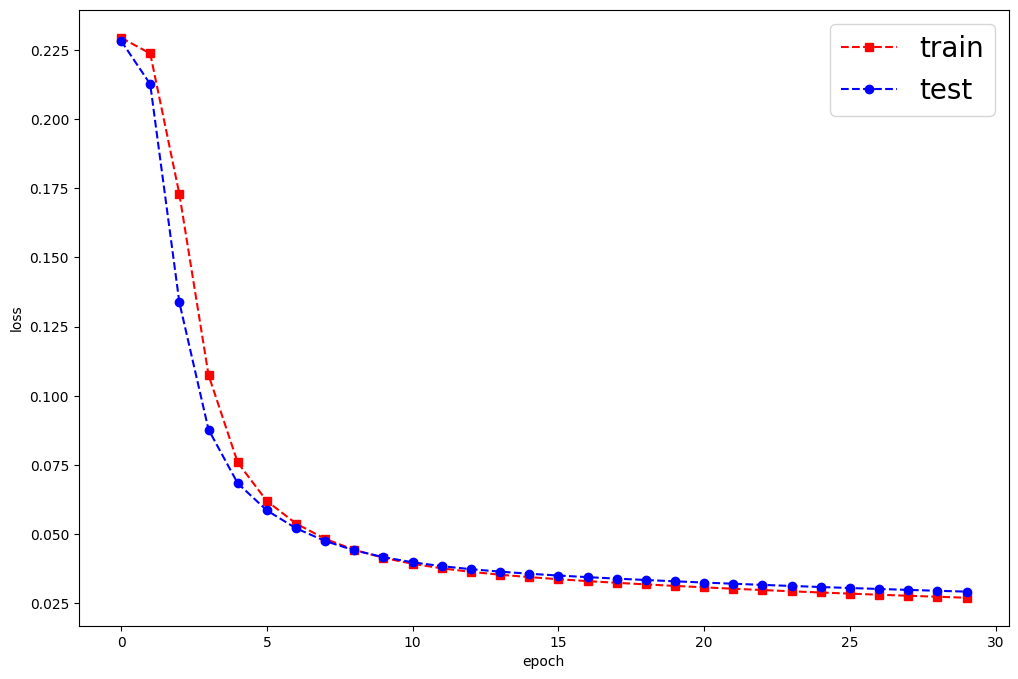

In [35]:
# Visualize the loss function for each epoch
fig = plt.subplots(figsize=(12,8))
plt.rcParams['font.size'] = 20

plt.plot(clf.log_loss, 'rs--')
plt.plot(clf.log_loss_val, 'bo--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

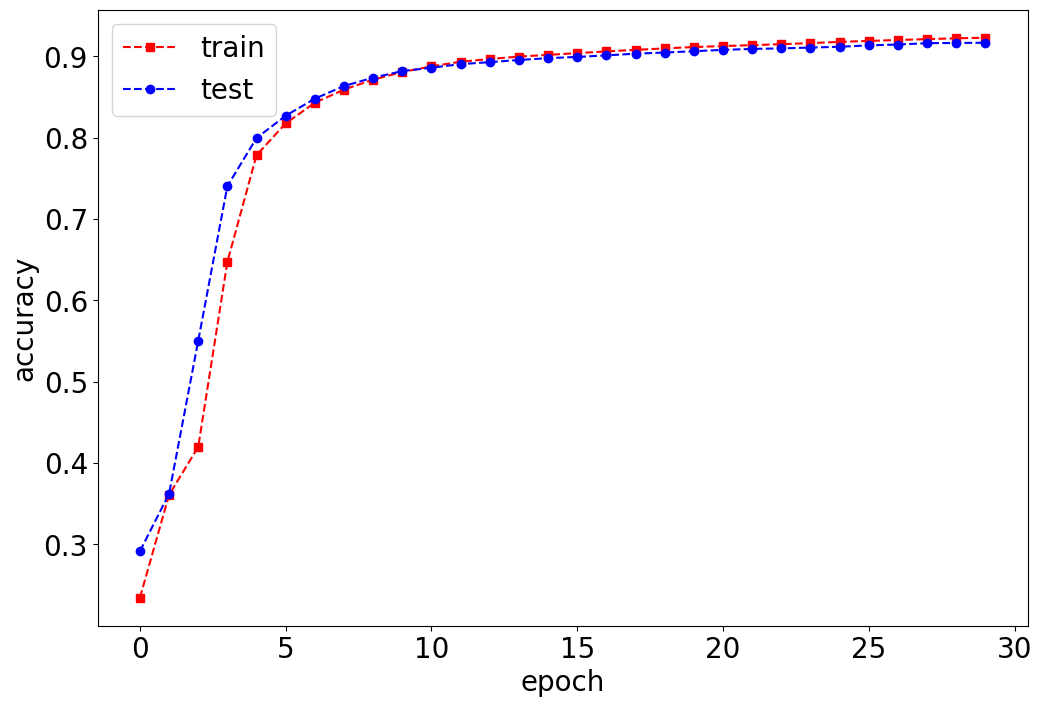

In [38]:
# Visualize the correct answer percentage for each epoch
fig = plt.subplots(figsize=(12,8))
plt.rcParams['font.size'] = 20

plt.plot(clf.log_acc, 'rs--')
plt.plot(clf.log_acc_val, 'bo--')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

[Problem 8] (Advance assignment) Confirmation of misclassification

Estimation result / Correct answer


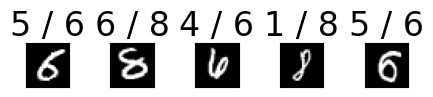

In [42]:
#y_pred = pred_test
import numpy as np
import matplotlib.pyplot as plt
num = 5
print('Estimation result / Correct answer')
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int64)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')